In [1]:
import importlib
from SpLSI import generate_topic_model as gen_model
from SpLSI import utils 
from SpLSI import splsi_
import numpy as np
import pandas as pd
import networkx as nx
import community as community_louvain  
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from types import SimpleNamespace
import time
import statistics
import contextlib
import random
import os
import sys
import warnings
import community as community_louvain  

/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri
from rpy2.robjects import numpy2ri

In [3]:
importlib.reload(gen_model)
importlib.reload(splsi_)
importlib.reload(utils)

<module 'SpLSI.utils' from '/Users/zhangzeyu/Downloads/research/SpLSI/SpLSI/utils.py'>

In [32]:
def simulation_spectral(k=4, iteration=10, sct_transform=True, maxiter=50):
    acc_spectral = []
    time_spectral = []
    acc_spectral_fast = []
    time_spectral_fast = []

    for i in range(iteration):
        coords_df = gen_model.generate_graph(100, 1000, 30, k, 0.05)
        W = gen_model.generate_W_strong(coords_df, 100, 1000, 30, k, 0.05) 
        L = np.diag(np.random.rand(min(W.shape)))
        V, _ = np.linalg.qr(np.random.randn(30, W.shape[0])) 
        X = W.T @ L @ V.T
        # X = X + np.random.normal(0, 0.02, X.shape)
        X = utils.euclidean_proj_simplex(X, s=1)
        X = utils.multinomial_from_rows(X,n=100)

        if sct_transform:
            numpy2ri.activate()
            pandas2ri.activate()
            seurat = rpackages.importr('Seurat')

            r_X_T = numpy2ri.py2rpy(X.T)
            robjects.globalenv['counts_matrix'] = r_X_T

            robjects.r('''
                library(Seurat)
                seurat_obj <- CreateSeuratObject(counts = as.matrix(counts_matrix))
                seurat_obj <- SCTransform(seurat_obj, verbose = FALSE)
                normalized_matrix <- as.data.frame(GetAssayData(seurat_obj, layer = "data", assay = "SCT"))
            ''')

            normalized_df = pandas2ri.rpy2py(robjects.globalenv['normalized_matrix'])
            X = normalized_df.to_numpy().T
            X = X - np.mean(X, axis=0)
        else:
            pass

        weights, edge_df = gen_model.generate_weights_edge(coords_df, 4, 0.05)

        start_time_1 = time.time()
        model_hooi = splsi_.SpLSI_(lamb_start=0.001,maxiter=maxiter,step_size=1.2,grid_len=29,method="hooi",verbose=0,eps=1e-05,normalize=True,L_inv_=True)
        model_hooi.fit(X, k, edge_df, weights)
        end_time_1 = time.time()
        running_time_1 = end_time_1 - start_time_1

        U = model_hooi.U
        acc_spectral.append(utils.group_and_compare_spectral(U, coords_df))
        time_spectral.append(running_time_1)

        start_time_2 = time.time()
        model_hooi_fast = splsi_.SpLSI_(lamb_start=0.001,maxiter=maxiter,step_size=1.2,grid_len=29,method="hooi",verbose=0,eps=1e-05,normalize=True,L_inv_=True, fast_option=True)
        model_hooi_fast.fit(X, k, edge_df, weights)
        end_time_2 = time.time()
        running_time_2 = end_time_2 - start_time_2

        U_fast = model_hooi_fast.U
        acc_spectral_fast.append(utils.group_and_compare_spectral(U_fast, coords_df))
        time_spectral_fast.append(running_time_2)


    return SimpleNamespace(acc_spectral=statistics.mean(acc_spectral), time_spectral=statistics.mean(time_spectral), acc_spectral_fast=statistics.mean(acc_spectral_fast), time_spectral_fast= statistics.mean(time_spectral_fast))

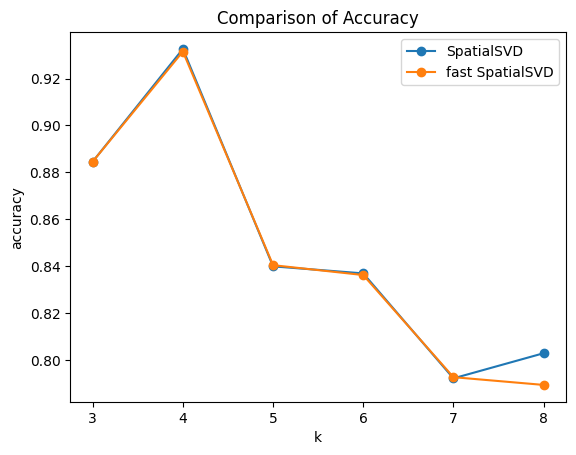

In [50]:
results = [result_3, result_4, result_5, result_6, result_7, result_8]

plt.plot(range(3, 9), [result.acc_spectral for result in results], marker='o', label='SpatialSVD')
plt.plot(range(3, 9), [result.acc_spectral_fast for result in results], marker='o', label='fast SpatialSVD')

plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Comparison of Accuracy')
plt.legend()
plt.show()

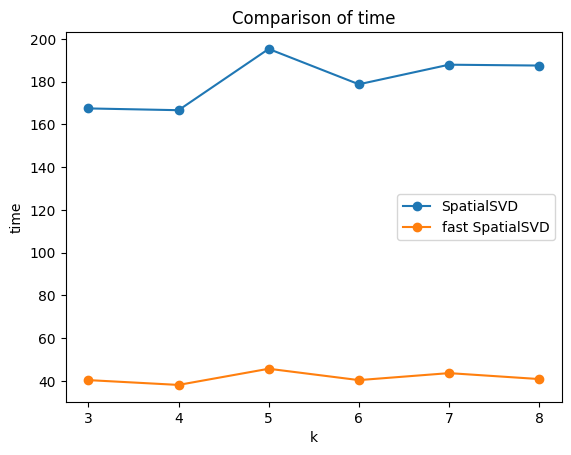

In [51]:
plt.plot(range(3, 9), [result.time_spectral for result in results], marker='o', label='SpatialSVD')
plt.plot(range(3, 9), [result.time_spectral_fast for result in results], marker='o', label='fast SpatialSVD')

plt.xlabel('k')
plt.ylabel('time')
plt.title('Comparison of time')
plt.legend()
plt.show()

In [ ]:
result_3 = simulation_spectral(k=3, iteration=10, sct_transform=True, maxiter=30)
result_4 = simulation_spectral(k=4, iteration=10, sct_transform=True, maxiter=30)
result_5 = simulation_spectral(k=5, iteration=10, sct_transform=True, maxiter=30)
result_6 = simulation_spectral(k=6, iteration=10, sct_transform=True, maxiter=30)
result_7 = simulation_spectral(k=7, iteration=10, sct_transform=True, maxiter=30)
result_8 = simulation_spectral(k=8, iteration=10, sct_transform=True, maxiter=30)